* Querol, Lorenzo
* Permito, Joshua
* Pineda, Ralph
* Abello, Hans Matthew

# Import Libraries

In [160]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.neural_network import MLPClassifier

RANDOM_STATE = 42 # Used for reproducibility

# Load Data

In [120]:
train_df = pd.read_csv('train_fruits_dataset.csv')
test_df = pd.read_csv('test_fruits_dataset.csv')

X_train, y_train = train_df.drop(['image', 'class'], axis=1), train_df['class']
X_test, y_test = test_df.drop(['image', 'class'], axis=1), test_df['class']
classnames = y_train.unique()

print("Train Set")
print(y_train.shape)
print(X_train.shape)

print("\nTest Set")
print(y_test.shape)
print(X_test.shape)

Train Set
(2723,)
(2723, 28)

Test Set
(672,)
(672, 28)


It can be seen that the data has 28 columns, 26 of which are features and 2 of which are the image path and the class. We can try to reduce the number of features using Recursive Feature Elimination (RFE) and Decision Forest Classifier later on.

# Exploratory Data Analysis

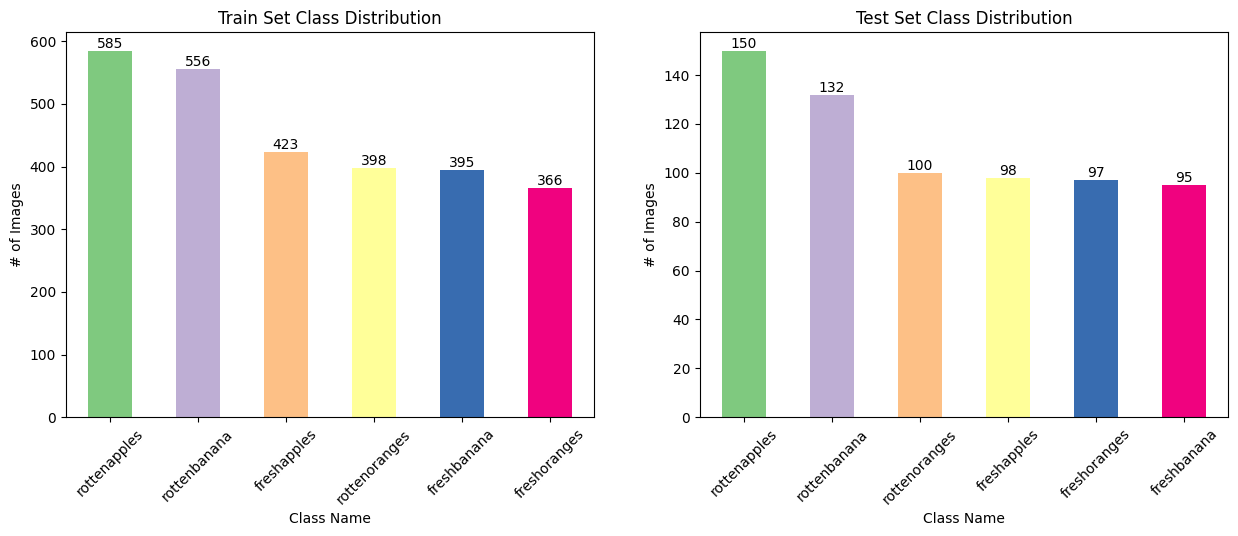

In [137]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
train_barplot = train_df['class'].value_counts().plot(
    kind='bar', color=plt.get_cmap("Accent").colors,  # type: ignore
    title='Train Set Class Distribution',
    xlabel='Class Name',
    rot=45,
    ylabel='# of Images',
    ax=ax[0])

for p in train_barplot.containers:  # type: ignore
    train_barplot.bar_label(p, fmt='%d', label_type='edge')

test_barplot = test_df['class'].value_counts().plot(
    kind='bar', color=plt.get_cmap("Accent").colors,  # type: ignore
    title='Test Set Class Distribution',
    xlabel='Class Name',
    rot=45,
    ylabel='# of Images',
    ax=ax[1])

for p in test_barplot.containers:  # type: ignore
    test_barplot.bar_label(p, fmt='%d', label_type='edge')

plt.show()

It can be seen that the data is slightly imbalanced, with the majority of the data belonging to the class 0. We will need to take this into account when training and evaluating our model to ensure that we are describing the performance accurately.

# Feature Selection

In [122]:
# ensures equal distribution of classes in each fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# model for feature selection
rfecv_model = DecisionTreeClassifier(random_state=RANDOM_STATE)

rfecv = RFECV(estimator=rfecv_model, cv=cv, scoring="f1_weighted")
rfecv = rfecv.fit(X_train, y_train)

In [123]:
print("The optimal number of features:", rfecv.n_features_)
print("Best features:", list(X_train.columns[rfecv.support_]))

X_train_filtered = X_train.loc[:, list(X_train.columns[rfecv.support_])]
X_test_filtered = X_test.loc[:, list(X_train.columns[rfecv.support_])]

The optimal number of features: 19
Best features: ['area', 'perimeter', 'circularity', 'convexity', 'green_mean', 'red_std', 'green_std', 'blue_std', 'red_skew', 'green_skew', 'green_kurt', 'h_mean', 's_mean', 'v_mean', 'h_std', 's_std', 's_skew', 's_kurt', 'v_kurt']


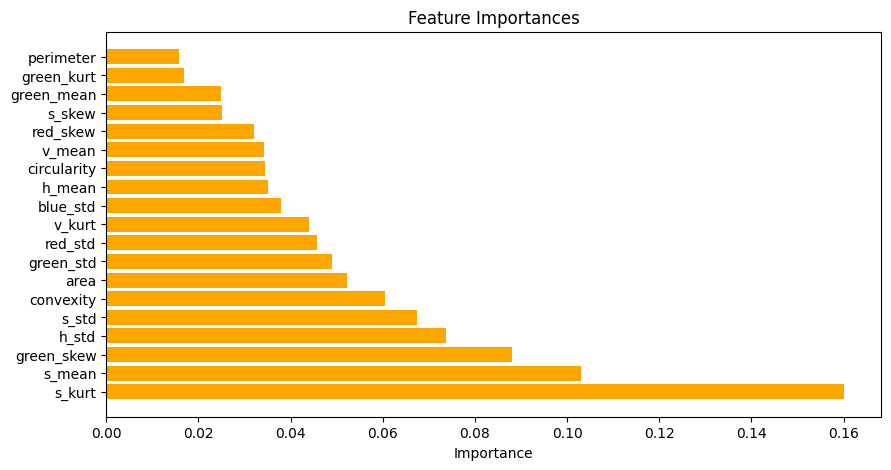

In [159]:
feat_set = pd.DataFrame()
feat_set['attribute'] = X_train_filtered.columns
feat_set['importance'] = rfecv.estimator_.feature_importances_

dset = feat_set.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 5))
plt.barh(y=dset['attribute'], width=dset['importance'], color='orange')
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.show()


The number of features has been reduced from 26 to 19 using RFE and Decision Forest Classifier. This can help reduce the training time and the complexity of the model. Based on the graph above, we can also see that `s_kurt` is a major contributor to the classification of the data, with `perimeter` not contributing much.

# Classification

### Define Models

In [125]:
def evaluate_model(pipeline, cv, X, y, params=None):

    if params:
        pipeline.set_params(**params)

    # Needs to be weighted to account for class imbalance
    scoring = ['balanced_accuracy', 'f1_weighted',
               'precision_weighted', 'recall_weighted']

    train_scores = cross_validate(pipeline,
                                  X,
                                  y,
                                  scoring=scoring,
                                  cv=cv,
                                  n_jobs=-1,
                                  return_train_score=True
                                  )
    
    print('\nTraining')
    print('Accuracy: %.4f' % np.mean(train_scores['train_balanced_accuracy']))
    print('F1 Score: %.4f' % np.mean(train_scores['train_f1_weighted']))
    print('Precision: %.4f' % np.mean(train_scores['train_precision_weighted']))
    print('Recall: %.4f' % np.mean(train_scores['train_recall_weighted']))

    print('\nValidation')
    print('Accuracy: %.4f' % np.mean(train_scores['test_balanced_accuracy']))
    print('F1 Score: %.4f' % np.mean(train_scores['test_f1_weighted']))
    print('Precision: %.4f' % np.mean(train_scores['test_precision_weighted']))
    print('Recall: %.4f' % np.mean(train_scores['test_recall_weighted']))

### Evaluation

In [154]:
mlp = MLPClassifier(
    hidden_layer_sizes=(100, 100, 100),
    activation='relu',
    solver='adam',
    alpha=0.01,
    random_state=RANDOM_STATE,
)

knn = KNeighborsClassifier(n_neighbors=3)

pipeline_mlp = Pipeline([
    ('scaler', StandardScaler()), 
    ('mlp', mlp)  
])

pipeline_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', knn)  
])

print('MLP')
evaluate_model(pipeline_mlp, cv, X_train_filtered, y_train, None)

print('\nKNN')
evaluate_model(pipeline_knn, cv, X_train_filtered, y_train, None)

MLP

Training
Accuracy: 0.9999
F1 Score: 0.9999
Precision: 0.9999
Recall: 0.9999

Validation
Accuracy: 0.9039
F1 Score: 0.9058
Precision: 0.9073
Recall: 0.9060

KNN

Training
Accuracy: 0.9086
F1 Score: 0.9090
Precision: 0.9097
Recall: 0.9098

Validation
Accuracy: 0.8036
F1 Score: 0.8002
Precision: 0.8023
Recall: 0.8035


### Prediction on Test Data

Let's get the evaluation metrics to assess the performance of the models on the test data.

In [144]:
# Train
model_mlp = pipeline_mlp.fit(X_train_filtered, y_train)
model_knn = pipeline_knn.fit(X_train_filtered, y_train)

# Predict
y_pred_mlp = model_mlp.predict(X_test_filtered)
y_pred_knn = model_knn.predict(X_test_filtered)

scores = {
    'MLP': {
        'Accuracy': balanced_accuracy_score(y_test, y_pred_mlp),
        'F1 Score': f1_score(y_test, y_pred_mlp, average='weighted'),
        'Precision': precision_score(y_test, y_pred_mlp, average='weighted'),
        'Recall': recall_score(y_test, y_pred_mlp, average='weighted')
    },
    'KNN': {
        
        'Accuracy': balanced_accuracy_score(y_test, y_pred_knn),
        'F1 Score': f1_score(y_test, y_pred_knn, average='weighted'),
        'Precision': precision_score(y_test, y_pred_knn, average='weighted'),
        'Recall': recall_score(y_test, y_pred_knn, average='weighted')
    }
}

print('\nMLP')
print('Accuracy: %.4f' % scores['MLP']['Accuracy'])
print('F1 Score: %.4f' % scores['MLP']['F1 Score'])
print('Precision: %.4f' % scores['MLP']['Precision'])
print('Recall: %.4f' % scores['MLP']['Recall'])

print('\nKNN')
print('Accuracy: %.4f' % scores['KNN']['Accuracy'])
print('F1 Score: %.4f' % scores['KNN']['F1 Score'])
print('Precision: %.4f' % scores['KNN']['Precision'])
print('Recall: %.4f' % scores['KNN']['Recall'])


MLP
Accuracy: 0.9329
F1 Score: 0.9332
Precision: 0.9334
Recall: 0.9330

KNN
Accuracy: 0.8156
F1 Score: 0.8085
Precision: 0.8111
Recall: 0.8110


Let's plot the confusion matrix of both models.

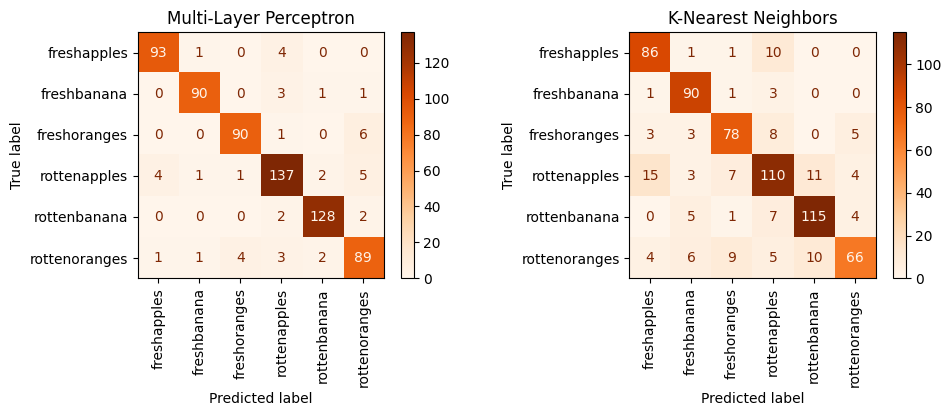

In [157]:
# Confusion Matrix
cm_mlp = confusion_matrix(y_test, y_pred_mlp)
cm_knn = confusion_matrix(y_test, y_pred_knn)

# Plot Confusion Matrix
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))

disp_mlp = ConfusionMatrixDisplay(
    confusion_matrix=cm_mlp, display_labels=classnames)
disp_mlp.plot(ax=ax1, cmap=plt.cm.Oranges)
ax1.set_title('Multi-Layer Perceptron')
ax1.set_xticklabels(classnames, rotation=90)

disp_knn = ConfusionMatrixDisplay(
    confusion_matrix=cm_knn, display_labels=classnames)
disp_knn.plot(ax=ax2, cmap=plt.cm.Oranges)
ax2.set_title('K-Nearest Neighbors')
ax2.set_xticklabels(classnames, rotation=90)

plt.tight_layout()
plt.show()